In [1]:
# 1. Imports and Seed Setting
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
os.chdir('C:\\Users\\7463X33\\Downloads\\Python Working Directory')

# Set random seeds for full reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

In [2]:
# 2. Load and Prepare Data
file_path = "filtered.xlsx"
df = pd.read_excel(file_path, usecols=[
                   'created_at', 'category_name_1', 'qty_ordered'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.to_period('W').apply(lambda r: r.start_time)


In [3]:
# 3. Aggregate Weekly
weekly = df.groupby(['category_name_1', 'week'])[
    'qty_ordered'].count().reset_index()
pivot = weekly.pivot(index='week', columns='category_name_1',
                     values='qty_ordered').fillna(0)
pivot.index = pd.to_datetime(pivot.index)

# 4. Log + Outlier Clipping
pivot_log = np.log1p(pivot)


def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean[col] = df[col].clip(lower=lower, upper=upper)
    return df_clean


pivot_clean = remove_outliers(pivot_log, pivot_log.columns)

In [4]:
# 5. Train/Test Split
train_size = len(pivot_clean) - 6
train_data = pivot_clean.iloc[:train_size]
test_data = pivot_clean.iloc[train_size:]

# 6. Scaling
scaler = RobustScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# 7. Sequence Creation


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


seq_len = 12
X_train, y_train = create_sequences(scaled_train, seq_len)
X_test, y_test = create_sequences(scaled_test, seq_len)


In [5]:
# 8. Build CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu',
           input_shape=(seq_len, X_train.shape[2])),
    Flatten(),
    Dense(X_train.shape[2])  # Multi-output
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1)

# 9. Predict
train_pred = model.predict(X_train)

last_seq = scaled_train[-seq_len:]
test_preds = []

for _ in range(len(test_data)):
    pred = model.predict(last_seq.reshape(1, seq_len, -1))[0]
    test_preds.append(pred)
    last_seq = np.roll(last_seq, -1, axis=0)
    last_seq[-1] = pred

test_preds = np.array(test_preds)

c:\Users\7463X33\Downloads\Anaconda1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6538
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5234 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4699 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4284 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3927 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3636 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3396 
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3187 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3003 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2840 
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2694 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2557 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2431 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2313 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [6]:
# 10. Inverse Transform + expm1
train_pred_rescaled = scaler.inverse_transform(train_pred)
test_preds_rescaled = scaler.inverse_transform(test_preds)
test_actual_rescaled = scaler.inverse_transform(scaled_test)

train_pred_final = np.expm1(train_pred_rescaled)
test_preds_final = np.expm1(test_preds_rescaled)
test_actual_final = np.expm1(test_actual_rescaled)

# 11. SMAPE Function


def smape(actual, forecast):
    denominator = (np.abs(actual) + np.abs(forecast)) / 2
    mask = denominator != 0
    return np.mean(np.abs(actual[mask] - forecast[mask]) / denominator[mask]) * 100

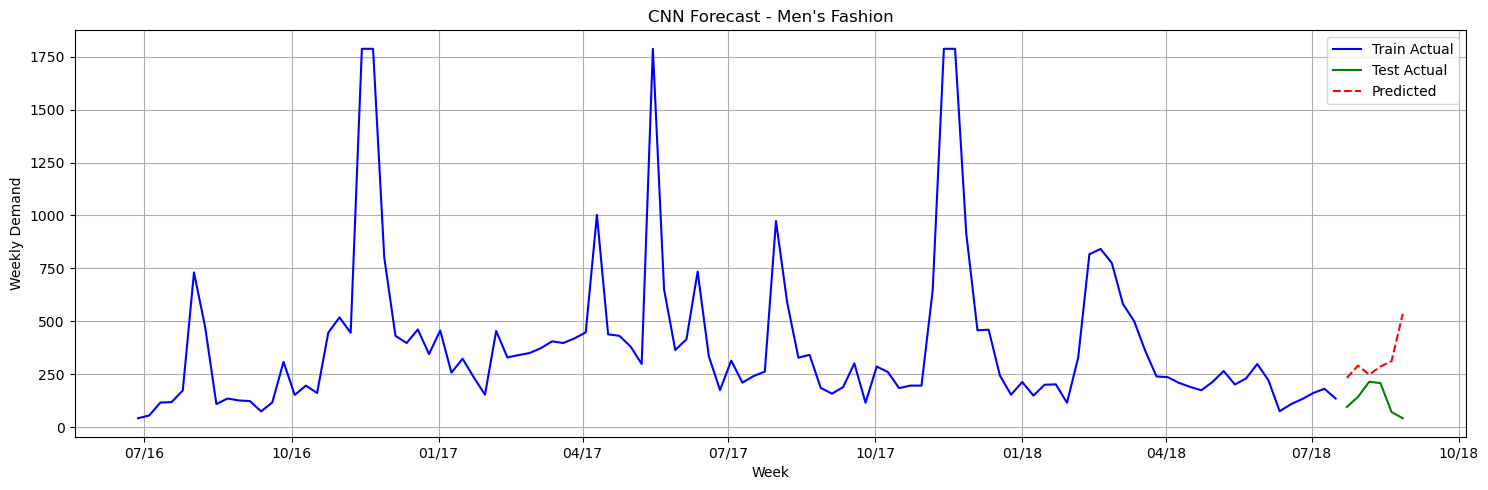

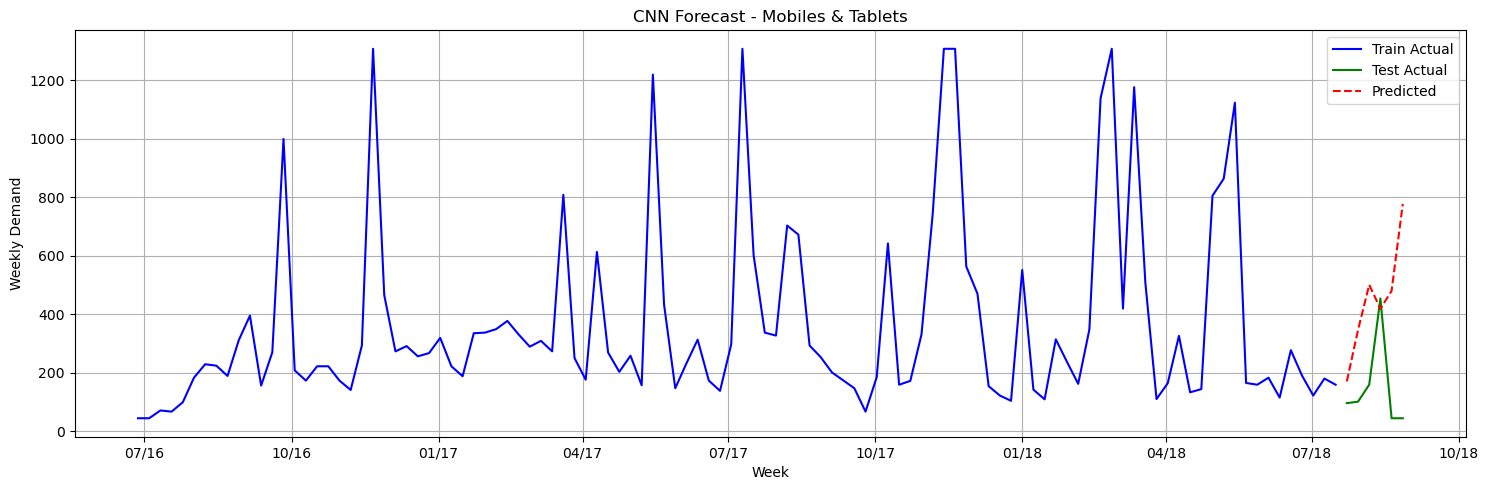

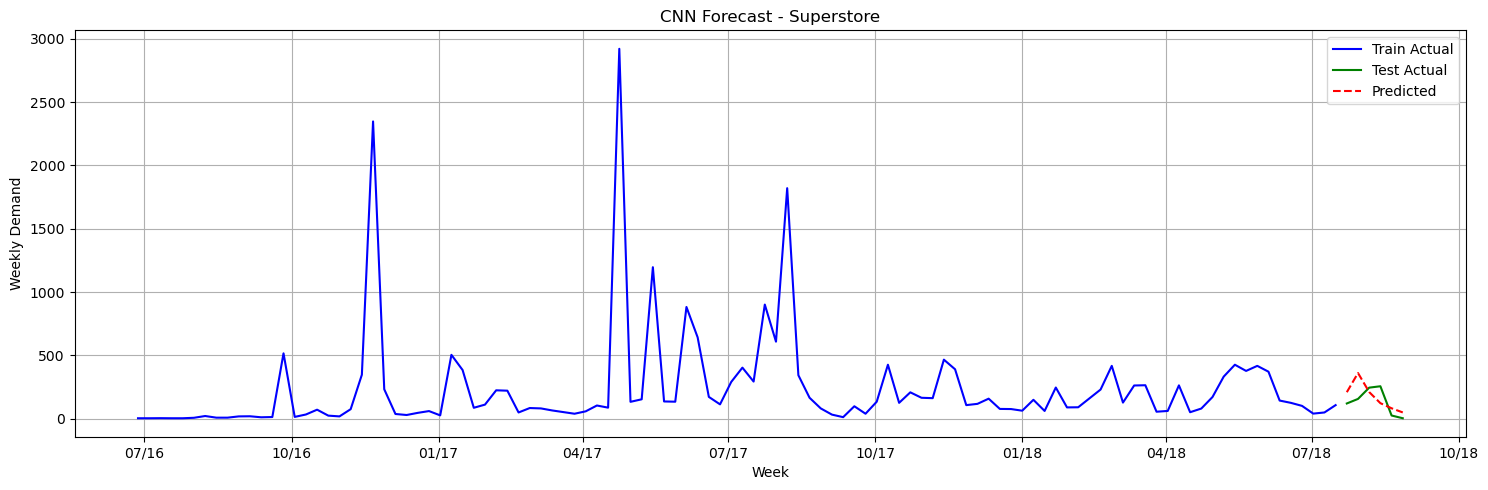

In [7]:
# 12. Plot Forecasts
for i, cat in enumerate(pivot.columns):
    plt.figure(figsize=(15, 5))
    plt.plot(train_data.index, np.expm1(
        train_data[cat]), label='Train Actual', color='blue')
    plt.plot(test_data.index,
             test_actual_final[:, i], label='Test Actual', color='green')
    plt.plot(test_data.index,
             test_preds_final[:, i], label='Predicted', color='red', linestyle='--')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    plt.title(f"CNN Forecast - {cat}")
    plt.xlabel("Week")
    plt.ylabel("Weekly Demand")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
# 13. Evaluation
metrics = []
mae_list = []
rmse_list = []
mape_list = []
smape_list = []

for i, cat in enumerate(pivot.columns):
    actual = test_actual_final[:, i]
    pred = test_preds_final[:, i]

    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))

    mask = actual != 0
    mape = np.mean(np.abs(
        (actual[mask] - pred[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan
    smape_val = smape(actual, pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    mape_list.append(mape)
    smape_list.append(smape_val)

    metrics.append({
        'Category': cat,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2),
        'SMAPE': round(smape_val, 2)
    })

print("\nCNN Forecasting Metrics:")
print(pd.DataFrame(metrics).to_string(index=False))

# Calculate overall average metrics
overall_mae = np.mean(mae_list)
overall_rmse = np.mean(rmse_list)
overall_mape = np.mean([m for m in mape_list if not np.isnan(m)]) if any(
    not np.isnan(m) for m in mape_list) else np.nan
overall_smape = np.mean(smape_list)

print("\nOverall Error Metrics for Test Set:")
print(f"Overall MAE: {round(overall_mae, 2)}")
print(f"Overall RMSE: {round(overall_rmse, 2)}")
print(
    f"Overall MAPE: {round(overall_mape, 2) if not np.isnan(overall_mape) else 'N/A'}%")
print(f"Overall SMAPE: {round(overall_smape, 2)}%")


CNN Forecasting Metrics:
         Category    MAE   RMSE   MAPE  SMAPE
    Men's Fashion 188.43 241.12 297.05  82.13
Mobiles & Tablets 310.66 389.34 529.27 103.60
       Superstore  94.13 111.15 311.01  83.38

Overall Error Metrics for Test Set:
Overall MAE: 197.74
Overall RMSE: 247.2
Overall MAPE: 379.11%
Overall SMAPE: 89.7%
